In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
surfdb = automap_base()

# reflect the tables
surfdb.prepare(engine, reflect=True)

In [8]:
# View all of the classes that automap found
surfdb.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
measure = surfdb.classes.measurement
station = surfdb.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
recent_date = session.query(measure.date).order_by(measure.date.desc()).first()
recent_date

('2017-08-23',)

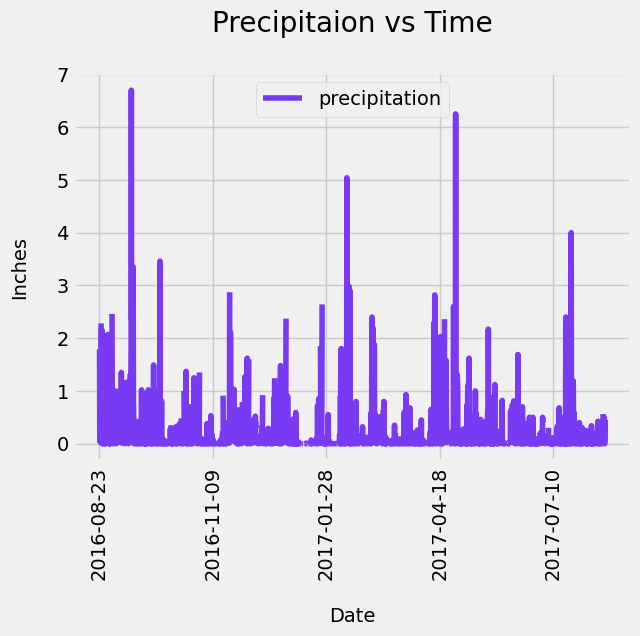

In [85]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
date_str = recent_date[0]
converted_date = dt.datetime.strptime(date_str,"%Y-%m-%d").date()

# Calculate the date one year from the last date in data set.
prev_year = converted_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = []
results = session.query(measure.date, measure.prcp).filter(measure.date >= prev_year).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
newdf = pd.DataFrame(results, columns=['date','precipitation'])
newdf.set_index(newdf['date'], inplace=True)

# Sort the dataframe by date
newdf = newdf.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
ax = newdf.plot(color="#783af2")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("Precipitaion vs Time\n")
ax.set_xlabel("\nDate")
ax.set_ylabel("Inches\n")

plt.savefig("Graphs/Graph1.png")
plt.show()

In [58]:
# Use Pandas to calculate the summary statistics for the precipitation data
newdf.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [59]:
# Design a query to calculate the total number of stations in the dataset
stations = session.query(func.count(station.station)).scalar()

stations

9

In [60]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(station.station, 
                                func.count(station.station)).filter(station.station == measure.station).\
                                    group_by(station.station).\
                                        order_by(func.count(station.station).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [61]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# Selecting the most active station from the above list
most_active = active_stations[0]
station_n = most_active[0]

#Using this information to generate the queries
lowest_temp = session.query(func.min(measure.tobs)).filter(station.station == measure.station).\
    filter(station.station == station_n).scalar()

highest_temp = session.query(func.max(measure.tobs)).\
    filter(station.station == measure.station).\
    filter(station.station == station_n).scalar()

avg_temp = session.query(func.avg(measure.tobs)).\
    filter(station.station == measure.station).\
    filter(station.station == station_n).scalar()

print(f'The lowest temperature of the most active station: {lowest_temp}')
print(f'The highest temperature of the most active station: {highest_temp}')
print(f'The average temperature of the most active station: {avg_temp}')

The lowest temperature of the most active station: 54.0
The highest temperature of the most active station: 85.0
The average temperature of the most active station: 71.66378066378067


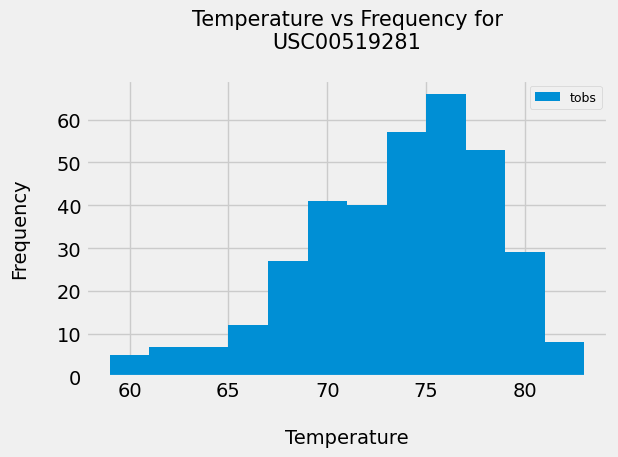

In [87]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(measure.tobs).filter(measure.station == station_n).\
    filter(measure.date >= prev_year).all()

df = pd.DataFrame(results, columns=['tobs'])
df.plot.hist(bins=12)

plt.title(f"Temperature vs Frequency for\n{station_n}\n", fontsize = 15)
plt.xlabel('\nTemperature')
plt.ylabel('Frequency\n')
plt.legend(fontsize = 9)
plt.tight_layout()

plt.savefig("Graphs/Graph2.png")
plt.show()

# Close Session

In [16]:
# Close Session
session.close()